# C2
# Предсказание отмены такси

## курс "Машинное обучение 2", программа OzonMasters, 2022

## Студент: Арешин Станислав Олегович

## EDA погодных данных 

В данном ноутбуке проводится анализ погодных данных. Главный вопрос в том, можно ли использовать эти признаки для обучения модели?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Джоиним погоду

In [15]:
df_train = pd.read_csv('1_data/train_data_w_dists.csv').assign(target=pd.read_csv('1_data/train_target.csv'), is_train=1)
df_test = pd.read_csv('1_data/test_data_w_dists.csv').assign(target=np.nan, is_train=0)
df = pd.concat([df_train, df_test], axis=0, sort=False, ignore_index=True)

moscow = pd.read_json('weather_data/group-city-moscow.jsonl', lines=True).assign(city='moscow')
spb = pd.read_json('weather_data/group-city-spb-fixed.jsonl', lines=True).assign(city='spb')
kazan = pd.read_json('weather_data/group-city-kazan.jsonl', lines=True).assign(city='kazan')
nnovgorod = pd.read_json('weather_data/group-city-nnovgorod.jsonl', lines=True).assign(city='nnovgorod')
voronezh = pd.read_json('weather_data/group-city-voronezh.jsonl', lines=True).assign(city='voronezh')
cities_weather = pd.concat([moscow, kazan, nnovgorod, voronezh, spb], axis=0, sort=False)

В тесте есть перепутанные lat lon, в обучении таких нет, но датафрейм общий, поэтому ниже немного другая функция, чем в основном ноутбуке.

In [26]:
def get_cities(df):
    df_res = df.copy()
    df_res['city'] = 'other'
    df_res.loc[df_res['lat'].between(59.4, 60.3) & df_res['lon'].between(29.23, 31.394), 'city'] = 'spb'
    df_res.loc[df_res['lat'].between(54.35, 56.7) & df_res['lon'].between(35.05, 39.86), 'city'] = 'moscow'
    df_res.loc[df_res['lat'].between(49.68, 52.03) & df_res['lon'].between(37.68, 43.35), 'city'] = 'voronezh'
    df_res.loc[df_res['lat'].between(55.95, 56.45) & df_res['lon'].between(43.38, 44.76), 'city'] = 'nnovgorod'
    df_res.loc[df_res['lat'].between(55.46, 55.94) & df_res['lon'].between(48.54, 50.06), 'city'] = 'kazan'

    df_res.loc[df_res['lon'].between(59.4, 60.3) & df_res['lat'].between(29.23, 31.394) & (df_res['city'] == 'other') \
               & (df_res['is_train'] == 0), 'city'] = 'spb'
    df_res.loc[df_res['lon'].between(54.35, 56.7) & df_res['lat'].between(35.05, 39.86) & (df_res['city'] == 'other') \
               & (df_res['is_train'] == 0), 'city'] = 'moscow'
    df_res.loc[df_res['lon'].between(49.68, 52.03) & df_res['lat'].between(37.68, 43.35) & (df_res['city'] == 'other') \
               & (df_res['is_train'] == 0), 'city'] = 'voronezh'
    df_res.loc[df_res['lon'].between(55.95, 56.45) & df_res['lat'].between(43.38, 44.76) & (df_res['city'] == 'other') \
               & (df_res['is_train'] == 0), 'city'] = 'nnovgorod'
    df_res.loc[df_res['lon'].between(55.46, 55.94) & df_res['lat'].between(48.54, 50.06) & (df_res['city'] == 'other') \
               & (df_res['is_train'] == 0), 'city'] = 'kazan'

    return df_res  

In [27]:
df = get_cities(df)
df.head()

,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,dist_to_N_NOVGOROD,dist_to_VORONEZH,min_dist_to_city,target,is_train,city
0,5117.239228,2014-01-22 04:10:00.000,econom,55.669290,37.474336,business,NaN,0.167112,8.316181,11.592866,6.564663,4.365016,0.167112,0.0,1,moscow
1,3638.726690,2014-01-10 13:45:00.000,econom,55.807461,37.635045,business,NaN,0.054601,8.385694,11.431060,6.392076,4.433008,0.054601,0.0,1,moscow
2,15143.069693,2014-03-02 02:10:00.000,econom,55.741105,37.615821,NaN,NaN,0.014794,8.401883,11.450610,6.416952,4.377908,0.014794,1.0,1,moscow
3,-1.000000,2014-02-26 13:20:00.000,econom,55.625526,37.618543,NaN,NaN,0.130305,8.462502,11.449373,6.425826,4.269358,0.130305,1.0,1,moscow
4,4708.142572,2014-01-21 19:45:00.000,business,55.813167,37.597863,NaN,NaN,0.060546,8.350529,11.468232,6.428677,4.451594,0.060546,0.0,1,moscow


Здесь выделяем необходимые временные данные для правильного джоина.

In [28]:
def get_datetime(df, col='due'):
    df_res = df.copy()
    df_res[col] = pd.to_datetime(df_res[col])
    df_res['month'] = df_res[col].dt.month
    df_res['day'] = df_res[col].dt.day
    df_res['hour'] = df_res[col].dt.hour
    return df_res 

In [30]:
df = get_datetime(df)
df.head()

,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,dist_to_N_NOVGOROD,dist_to_VORONEZH,min_dist_to_city,target,is_train,city,month,day,hour
0,5117.239228,2014-01-22 04:10:00,econom,55.669290,37.474336,business,NaN,0.167112,8.316181,11.592866,6.564663,4.365016,0.167112,0.0,1,moscow,1,22,4
1,3638.726690,2014-01-10 13:45:00,econom,55.807461,37.635045,business,NaN,0.054601,8.385694,11.431060,6.392076,4.433008,0.054601,0.0,1,moscow,1,10,13
2,15143.069693,2014-03-02 02:10:00,econom,55.741105,37.615821,NaN,NaN,0.014794,8.401883,11.450610,6.416952,4.377908,0.014794,1.0,1,moscow,3,2,2
3,-1.000000,2014-02-26 13:20:00,econom,55.625526,37.618543,NaN,NaN,0.130305,8.462502,11.449373,6.425826,4.269358,0.130305,1.0,1,moscow,2,26,13
4,4708.142572,2014-01-21 19:45:00,business,55.813167,37.597863,NaN,NaN,0.060546,8.350529,11.468232,6.428677,4.451594,0.060546,0.0,1,moscow,1,21,19


In [31]:
cities_weather = get_datetime(cities_weather, col='time')
cities_weather.head()

,time,summary,icon,precip_intensity,precip_probability,precip_type,precipAccumulation,temperature,apparent_temperature,dew_point,...,wind_gust,wind_bearing,cloud_cover,uv_index,visibility,ozone,city,month,day,hour
0,2014-01-01 00:00:00,Overcast,cloudy,0.0,0.0,NaN,NaN,1.52,-1.09,-2.32,...,4.91,262.0,1.00,0.0,10.003,NaN,moscow,1,1,0
1,2014-01-01 01:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,NaN,NaN,1.54,-1.13,-2.39,...,4.91,242.0,0.77,0.0,10.003,NaN,moscow,1,1,1
2,2014-01-01 02:00:00,Overcast,cloudy,0.0,0.0,NaN,NaN,1.32,-1.16,-2.34,...,4.91,246.0,1.00,0.0,10.003,NaN,moscow,1,1,2
3,2014-01-01 03:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,NaN,NaN,1.44,-1.14,-2.08,...,3.57,243.0,0.87,0.0,10.003,NaN,moscow,1,1,3
4,2014-01-01 04:00:00,Overcast,cloudy,0.0,0.0,NaN,NaN,1.61,1.61,-2.49,...,3.57,245.0,1.00,0.0,10.003,NaN,moscow,1,1,4


Джоиним полученные датафреймы 

In [32]:
%%time

res = df.merge(cities_weather, how='left', left_on=['city', 'month', 'day', 'hour'], right_on=['city', 'month', 'day', 'hour'])
res.head()

Wall time: 1.13 s


,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,...,dew_point,humidity,pressure,wind_speed,wind_gust,wind_bearing,cloud_cover,uv_index,visibility,ozone
0,5117.239228,2014-01-22 04:10:00,econom,55.669290,37.474336,business,NaN,0.167112,8.316181,11.592866,...,-20.76,0.85,1030.4,0.00,0.45,NaN,0.04,0.0,3.572,NaN
1,3638.726690,2014-01-10 13:45:00,econom,55.807461,37.635045,business,NaN,0.054601,8.385694,11.431060,...,1.63,0.87,999.6,3.69,9.71,163.0,1.00,0.0,10.003,NaN
2,15143.069693,2014-03-02 02:10:00,econom,55.741105,37.615821,NaN,NaN,0.014794,8.401883,11.450610,...,-6.27,0.70,NaN,2.63,4.91,134.0,1.00,0.0,9.995,NaN
3,-1.000000,2014-02-26 13:20:00,econom,55.625526,37.618543,NaN,NaN,0.130305,8.462502,11.449373,...,-12.32,0.39,1037.4,1.52,4.47,142.0,0.72,1.0,9.988,NaN
4,4708.142572,2014-01-21 19:45:00,business,55.813167,37.597863,NaN,NaN,0.060546,8.350529,11.468232,...,-15.79,0.89,1032.5,1.16,2.23,262.0,NaN,0.0,9.988,NaN


In [33]:
res.columns

Index(['dist', 'due', 'f_class', 'lat', 'lon', 's_class', 't_class',
       'dist_to_MOSCOW', 'dist_to_SPB', 'dist_to_KAZAN', 'dist_to_N_NOVGOROD',
       'dist_to_VORONEZH', 'min_dist_to_city', 'target', 'is_train', 'city',
       'month', 'day', 'hour', 'time', 'summary', 'icon', 'precip_intensity',
       'precip_probability', 'precip_type', 'precipAccumulation',
       'temperature', 'apparent_temperature', 'dew_point', 'humidity',
       'pressure', 'wind_speed', 'wind_gust', 'wind_bearing', 'cloud_cover',
       'uv_index', 'visibility', 'ozone'],
      dtype='object')

In [34]:
res.drop(['month', 'day', 'hour', 'time', 'city'], axis=1, inplace=True)
res.head()

,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,...,dew_point,humidity,pressure,wind_speed,wind_gust,wind_bearing,cloud_cover,uv_index,visibility,ozone
0,5117.239228,2014-01-22 04:10:00,econom,55.669290,37.474336,business,NaN,0.167112,8.316181,11.592866,...,-20.76,0.85,1030.4,0.00,0.45,NaN,0.04,0.0,3.572,NaN
1,3638.726690,2014-01-10 13:45:00,econom,55.807461,37.635045,business,NaN,0.054601,8.385694,11.431060,...,1.63,0.87,999.6,3.69,9.71,163.0,1.00,0.0,10.003,NaN
2,15143.069693,2014-03-02 02:10:00,econom,55.741105,37.615821,NaN,NaN,0.014794,8.401883,11.450610,...,-6.27,0.70,NaN,2.63,4.91,134.0,1.00,0.0,9.995,NaN
3,-1.000000,2014-02-26 13:20:00,econom,55.625526,37.618543,NaN,NaN,0.130305,8.462502,11.449373,...,-12.32,0.39,1037.4,1.52,4.47,142.0,0.72,1.0,9.988,NaN
4,4708.142572,2014-01-21 19:45:00,business,55.813167,37.597863,NaN,NaN,0.060546,8.350529,11.468232,...,-15.79,0.89,1032.5,1.16,2.23,262.0,NaN,0.0,9.988,NaN


In [37]:
res.to_csv('data_w_weather_dist.csv', index=False)

# Рисуем погоду

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

In [2]:
df = pd.read_csv('data_w_weather_dist.csv').drop(['ozone'], axis=1)
df.head()

,dist,due,f_class,lat,lon,s_class,t_class,dist_to_MOSCOW,dist_to_SPB,dist_to_KAZAN,...,apparent_temperature,dew_point,humidity,pressure,wind_speed,wind_gust,wind_bearing,cloud_cover,uv_index,visibility
0,5117.239228,2014-01-22 04:10:00.000,econom,55.669290,37.474336,business,NaN,0.167112,8.316181,11.592866,...,-18.80,-20.76,0.85,1030.4,0.00,0.45,NaN,0.04,0.0,3.572
1,3638.726690,2014-01-10 13:45:00.000,econom,55.807461,37.635045,business,NaN,0.054601,8.385694,11.431060,...,0.26,1.63,0.87,999.6,3.69,9.71,163.0,1.00,0.0,10.003
2,15143.069693,2014-03-02 02:10:00.000,econom,55.741105,37.615821,NaN,NaN,0.014794,8.401883,11.450610,...,-4.83,-6.27,0.70,NaN,2.63,4.91,134.0,1.00,0.0,9.995
3,-1.000000,2014-02-26 13:20:00.000,econom,55.625526,37.618543,NaN,NaN,0.130305,8.462502,11.449373,...,-1.85,-12.32,0.39,1037.4,1.52,4.47,142.0,0.72,1.0,9.988
4,4708.142572,2014-01-21 19:45:00.000,business,55.813167,37.597863,NaN,NaN,0.060546,8.350529,11.468232,...,-14.37,-15.79,0.89,1032.5,1.16,2.23,262.0,NaN,0.0,9.988


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698398 entries, 0 to 1698397
Data columns (total 32 columns):
 #   Column                Dtype  
---  ------                -----  
 0   dist                  float64
 1   due                   object 
 2   f_class               object 
 3   lat                   float64
 4   lon                   float64
 5   s_class               object 
 6   t_class               object 
 7   dist_to_MOSCOW        float64
 8   dist_to_SPB           float64
 9   dist_to_KAZAN         float64
 10  dist_to_N_NOVGOROD    float64
 11  dist_to_VORONEZH      float64
 12  min_dist_to_city      float64
 13  target                float64
 14  is_train              int64  
 15  summary               object 
 16  icon                  object 
 17  precip_intensity      float64
 18  precip_probability    float64
 19  precip_type           object 
 20  precipAccumulation    float64
 21  temperature           float64
 22  apparent_temperature  float64
 23  dew_poi

## Непрерывные числовые признаки

### Распределния признаков на обучении и тесте

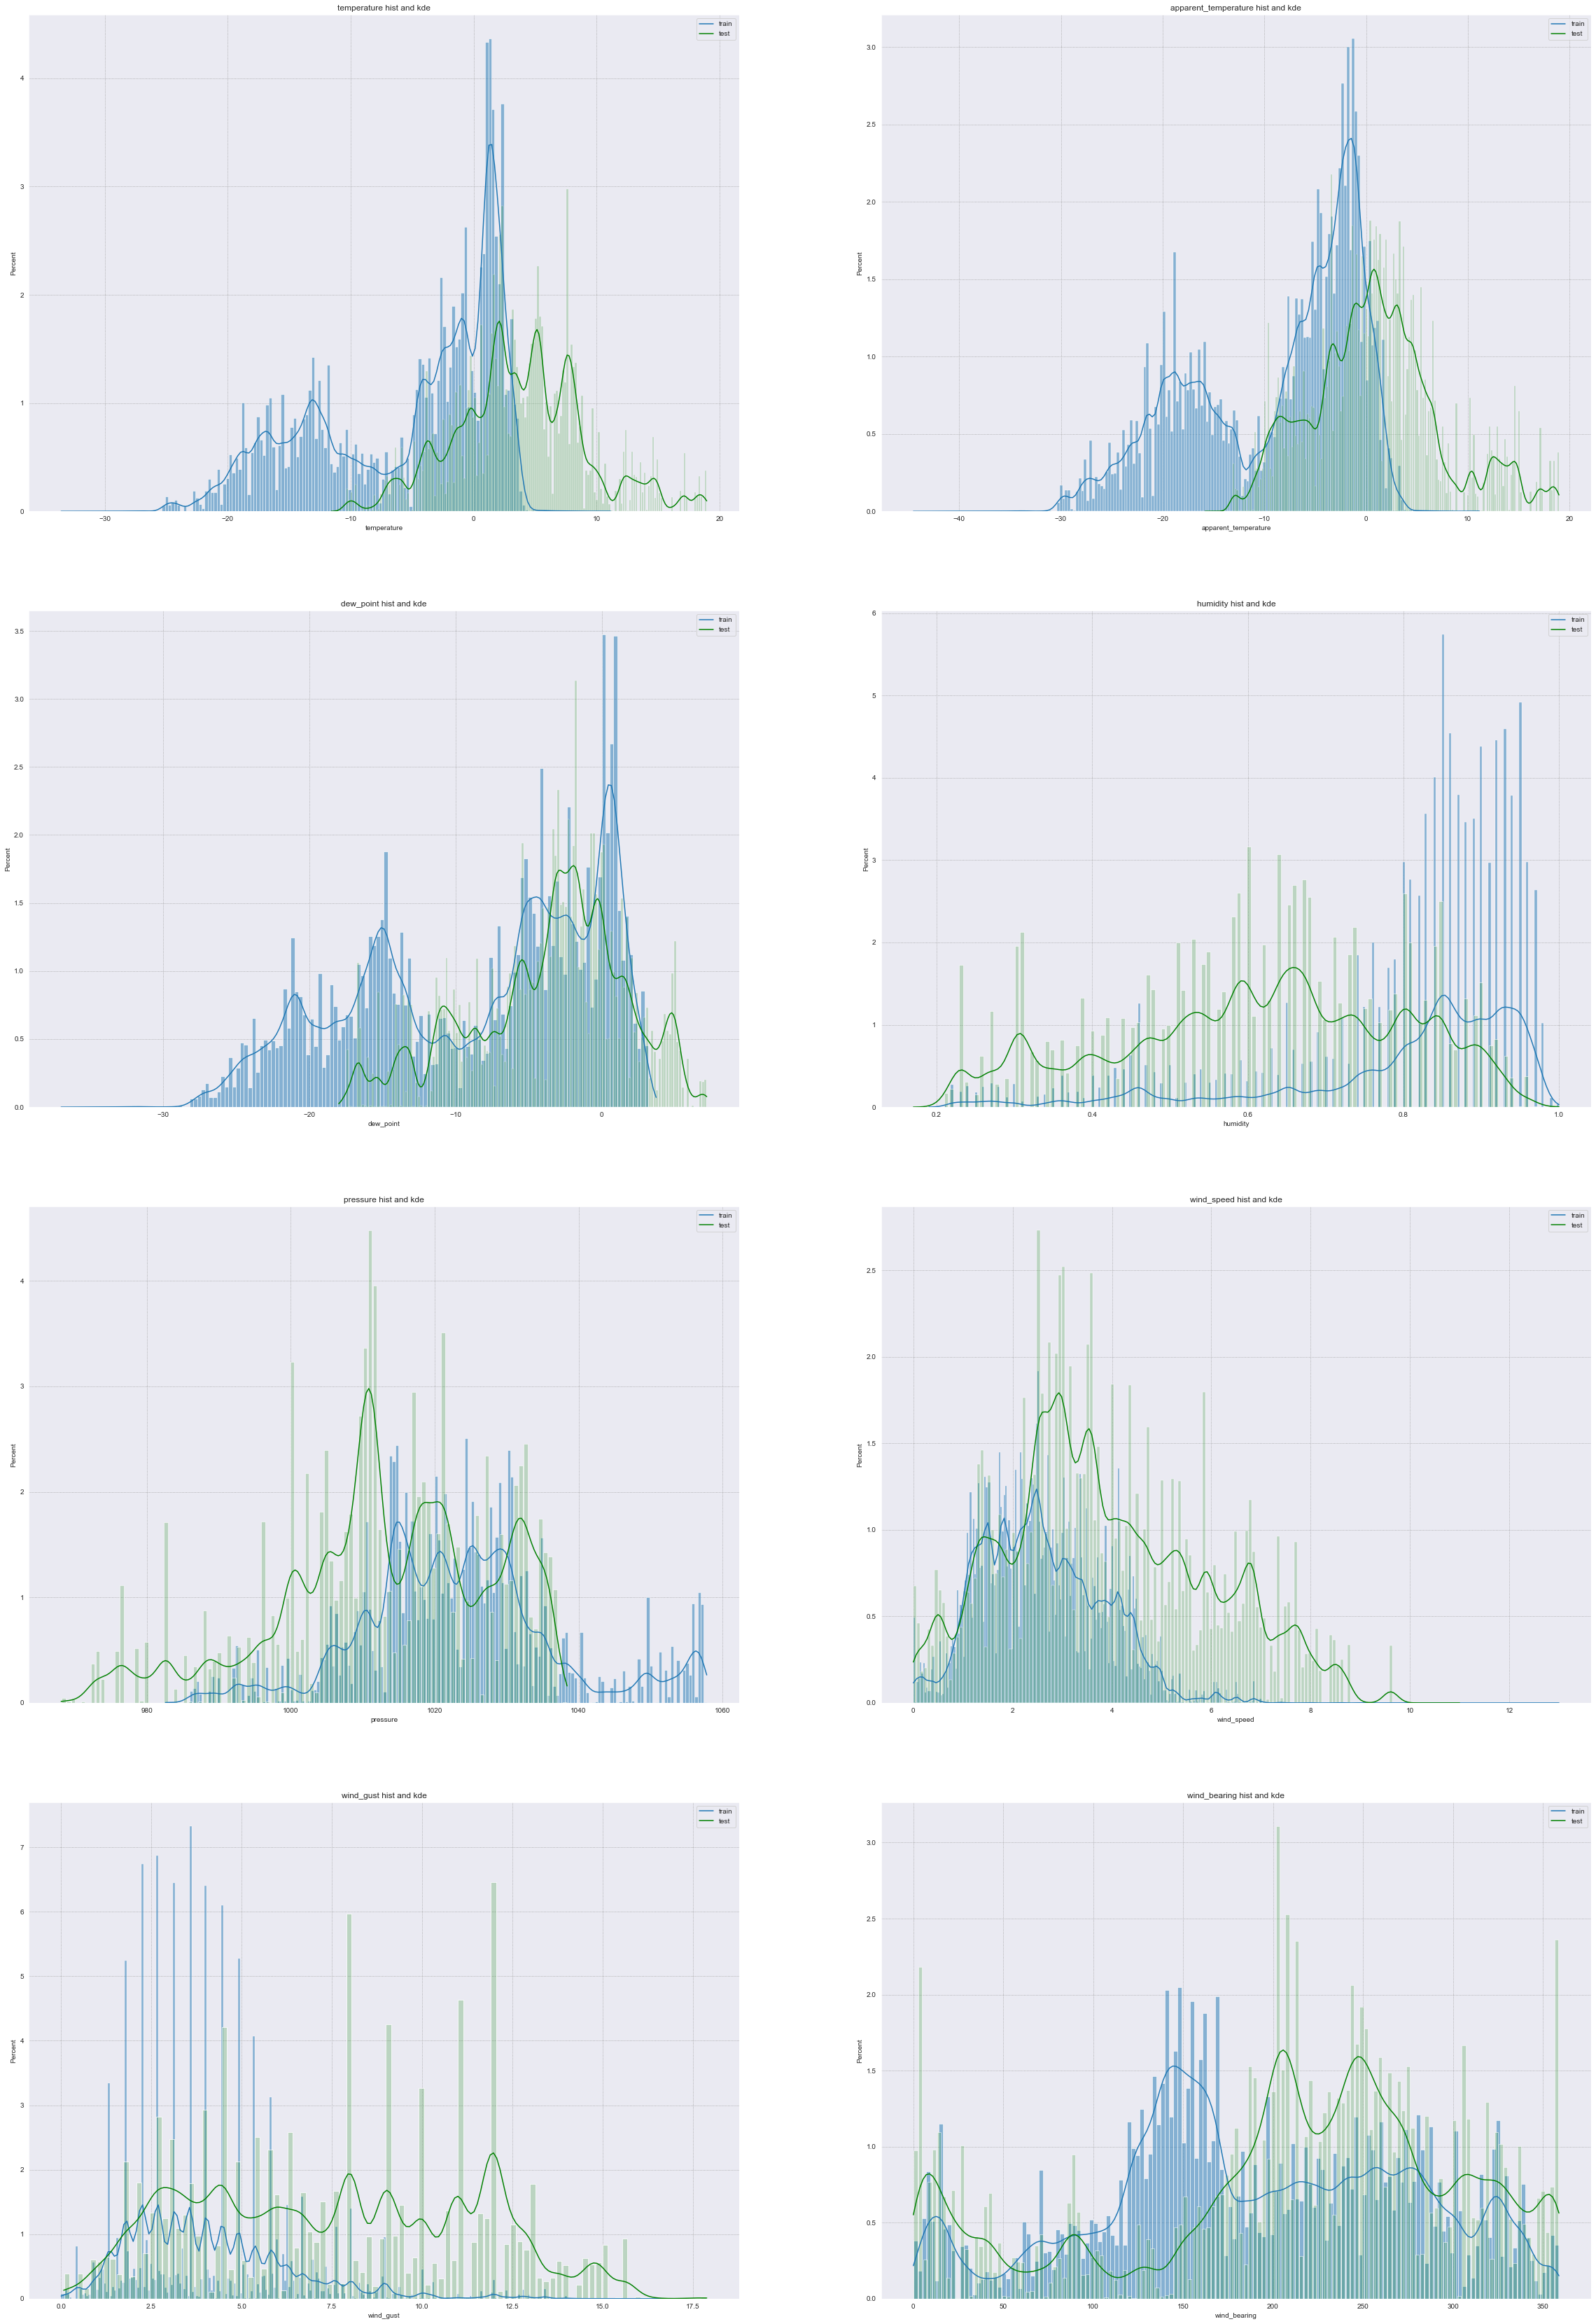

In [15]:
float_features = ['temperature', 'apparent_temperature', 'dew_point', 'humidity',\
                  'pressure', 'wind_speed', 'wind_gust', 'wind_bearing']

fig = plt.figure(figsize=(40,60))
plt.axis('off')

for i, feat in enumerate(float_features):
    ax = fig.add_subplot(int(len(float_features) / 2), 2, i + 1)
    ax.set_title(f'{feat} hist and kde')
    sns.histplot(data=df[df['target'] == df['target']], x=feat, label='train', ax=ax, kde=True, stat='percent')
    sns.histplot(data=df[df['target'] != df['target']], x=feat, label='test', ax=ax, kde=True,\
                     color='green', stat='percent', shrink=.8, alpha=.2)
    ax.legend(['train', 'test'])
    ax.set_xlabel(feat)

* 'temperature', 'apparent_temperature' сильно смещены на тесте, наступила весна))
* 'dew_point', 'humidity' тоже едут на тесте
* 'pressure' смещено, а вот 'wind_speed' пусть с смещен, но не так сильно и можно попробовать добавить как фичу
* 'wind_gust', 'wind_bearing' сильно смещены

### Распределение признаков обучения по таргету

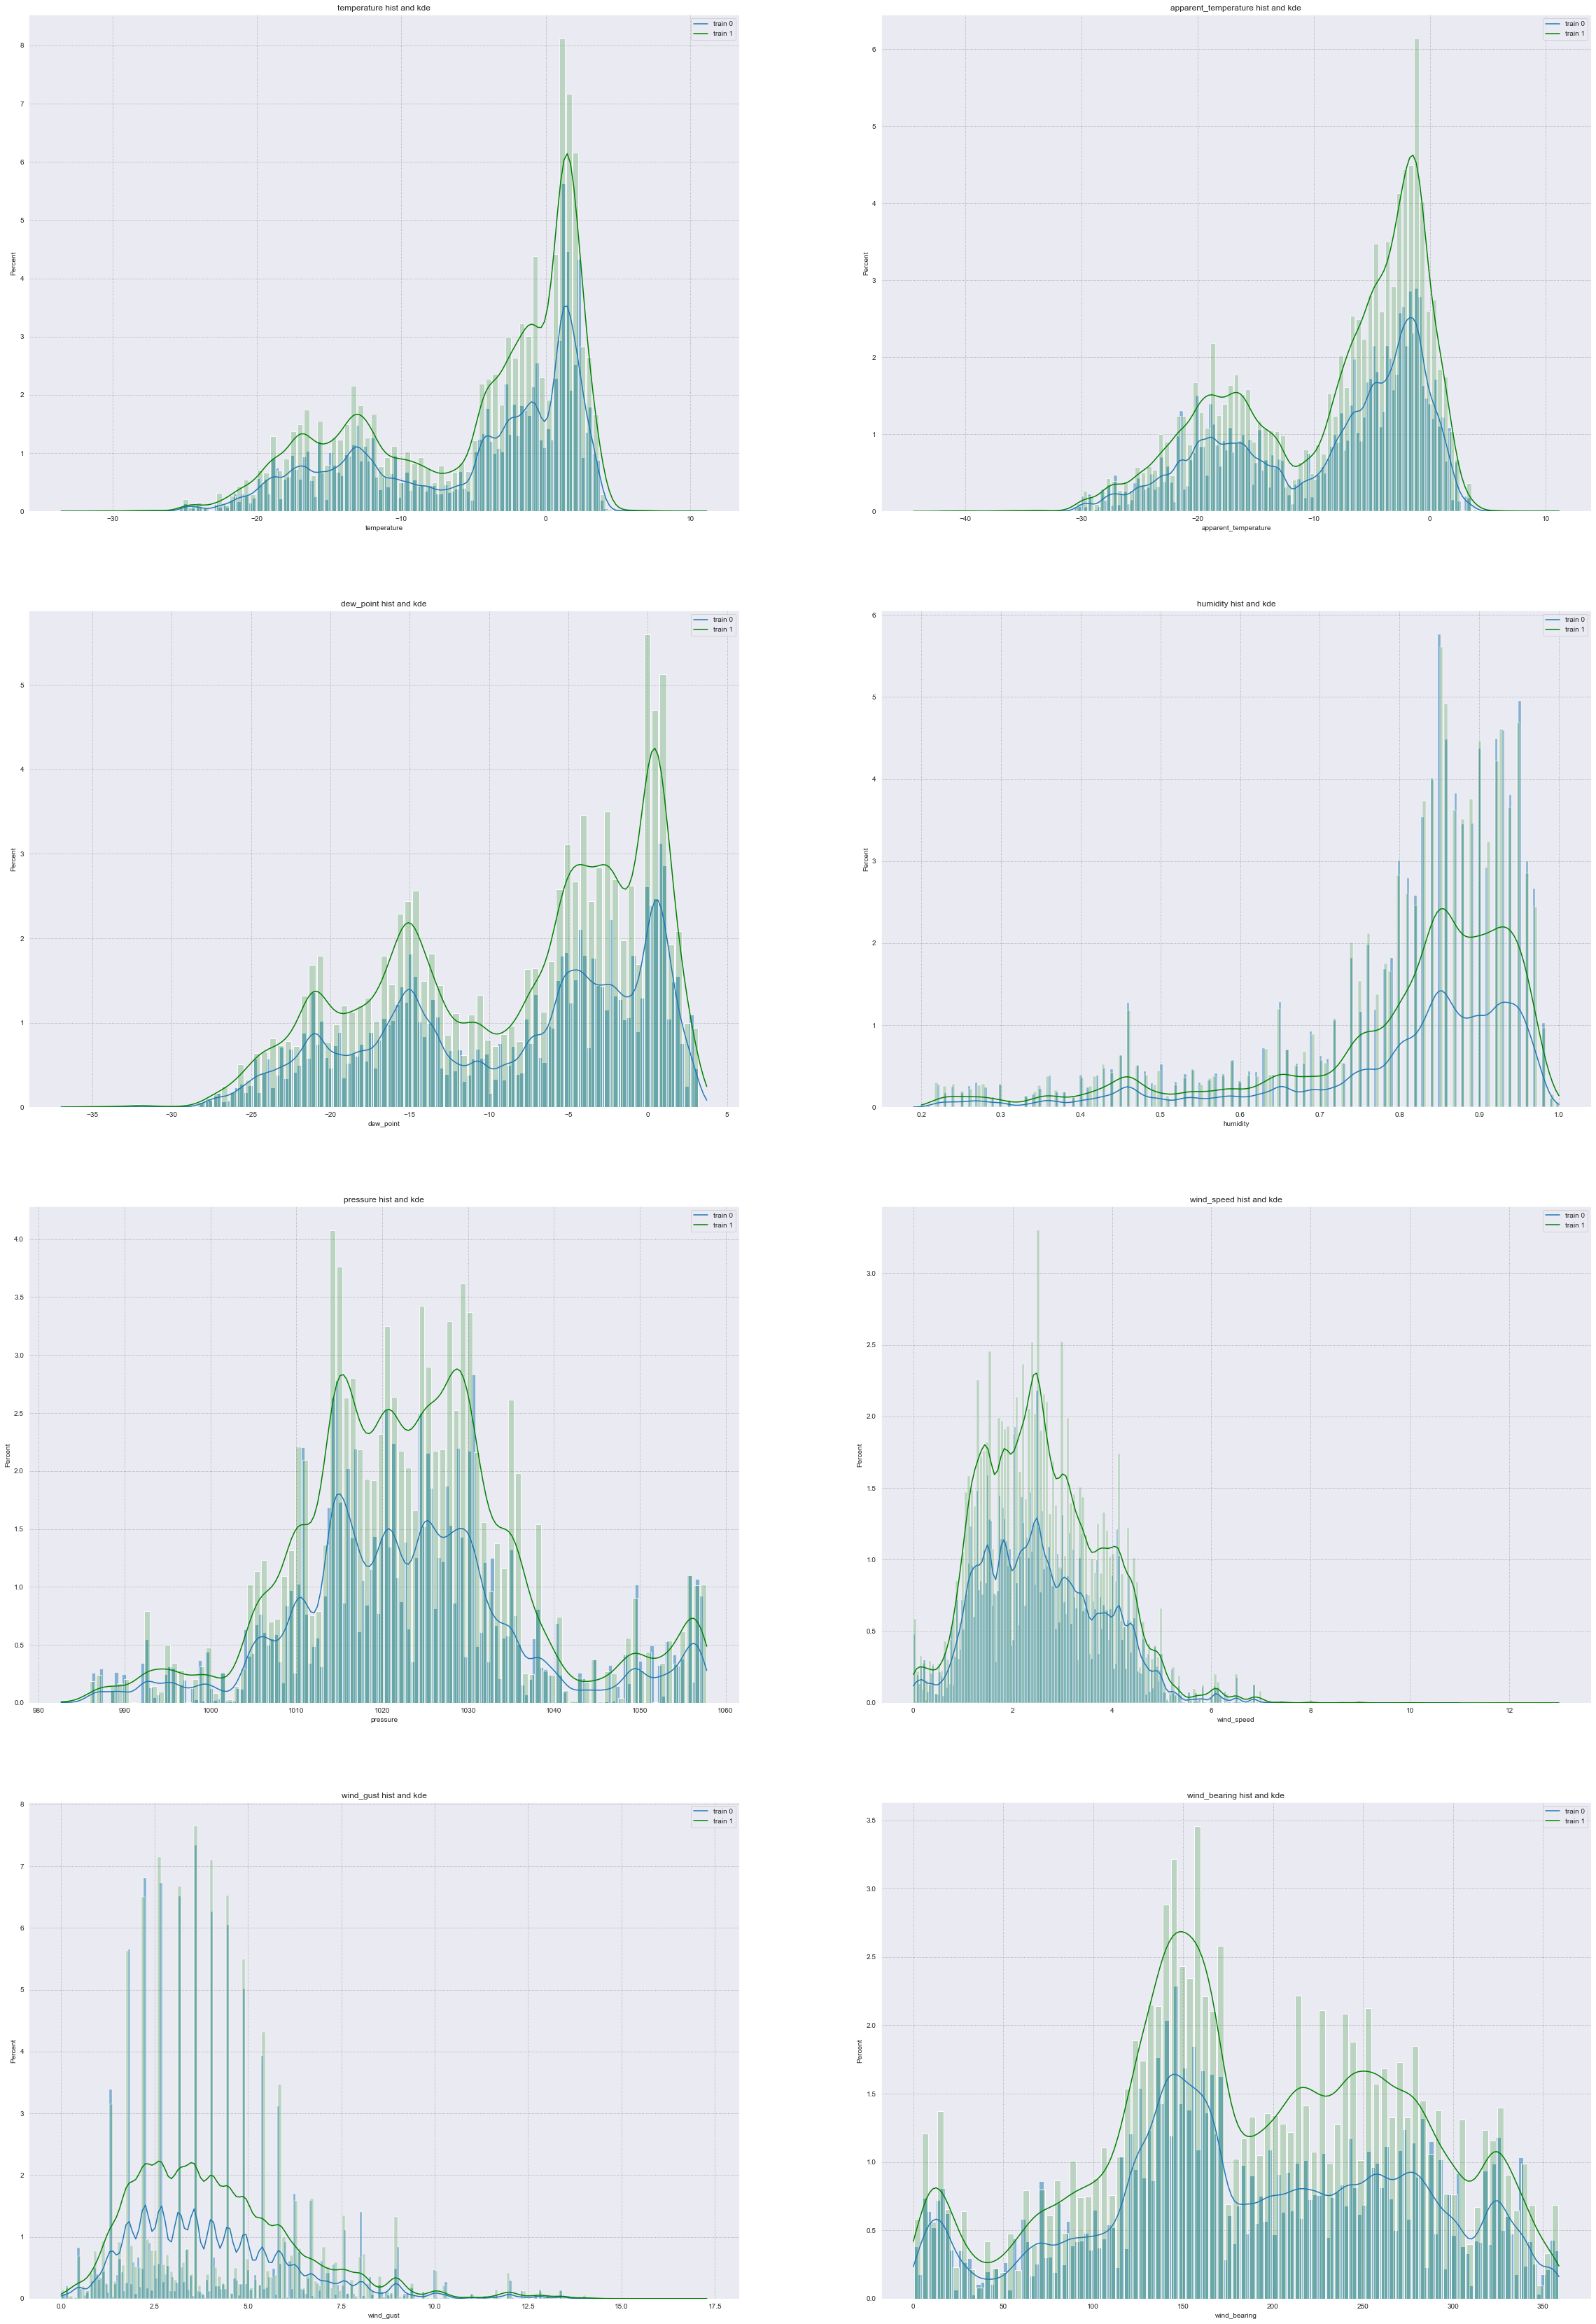

In [16]:
float_features = ['temperature', 'apparent_temperature', 'dew_point', 'humidity',\
                  'pressure', 'wind_speed', 'wind_gust', 'wind_bearing']

fig = plt.figure(figsize=(40,60))
plt.axis('off')

for i, feat in enumerate(float_features):
    ax = fig.add_subplot(int(len(float_features) / 2), 2, i + 1)
    ax.set_title(f'{feat} hist and kde')
    sns.histplot(data=df[df['target'] == 0], x=feat, label='train 0', ax=ax, kde=True, stat='percent')
    sns.histplot(data=df[df['target'] == 1], x=feat, label='train 1', ax=ax, kde=True,\
                     color='green', stat='percent', shrink=.8, alpha=.2)
    ax.legend(['train 0', 'train 1'])
    ax.set_xlabel(feat)

По всем погодным признакам видно разделение по таргету. Попробуем подвигать некоторые распределения и получить более менее похожие из них

### Двигаем распределения 

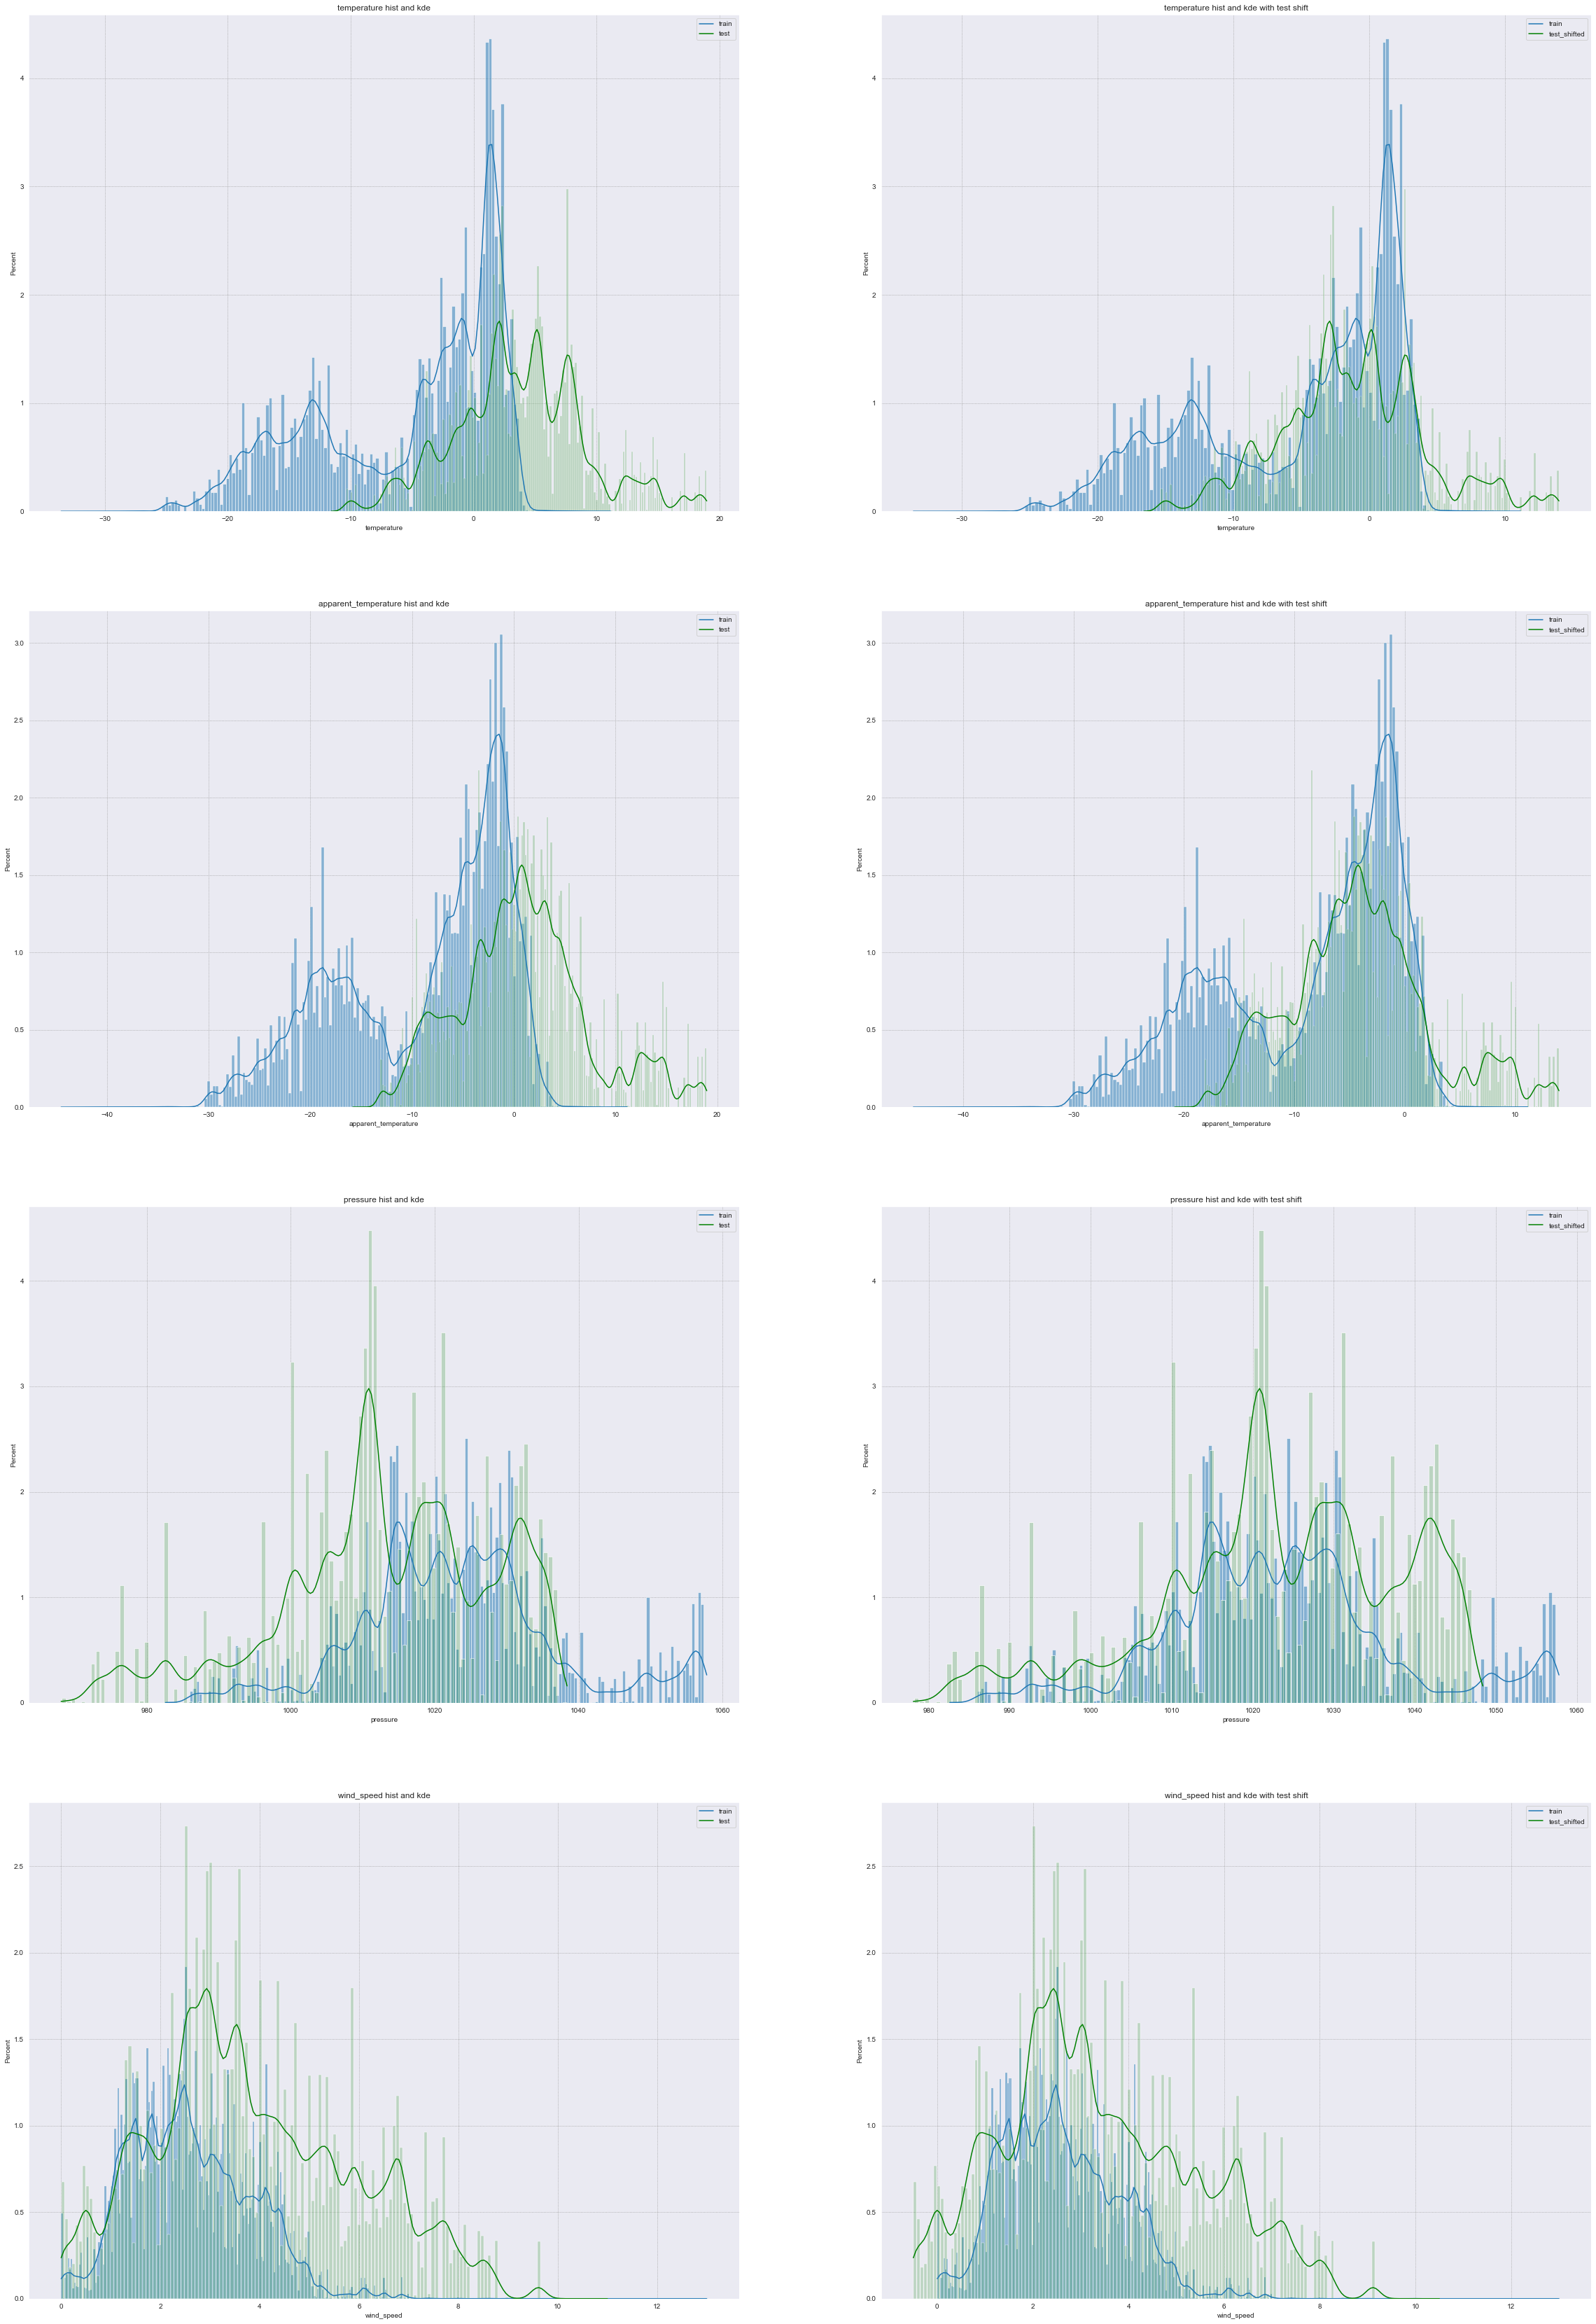

In [43]:
float_features_shift = {
    'temperature' : -5,
    'apparent_temperature': -5,
    'pressure': 10, 
    'wind_speed': -0.5,
}

fig = plt.figure(figsize=(40,60))
plt.axis('off')

i = 1
for feat, shift in float_features_shift.items():
    ax = fig.add_subplot(len(float_features_shift), 2, i)
    ax.set_title(f'{feat} hist and kde')
    sns.histplot(data=df[df['target'] == df['target']], x=feat, ax=ax, kde=True, stat='percent')
    sns.histplot(data=df[df['target'] != df['target']], x=feat, ax=ax, kde=True,\
                     color='green', stat='percent', shrink=.8, alpha=.2)
    ax.legend(['train', 'test'])
    ax.set_xlabel(feat)
    i += 1
    
    ax = fig.add_subplot(len(float_features_shift), 2, i)
    ax.set_title(f'{feat} hist and kde with test shift')
    sns.histplot(data=df[df['target'] == df['target']], x=feat, ax=ax, kde=True, stat='percent')
    sns.histplot(data=df[df['target'] != df['target']][feat] + shift, ax=ax, kde=True,\
                     color='green', stat='percent', shrink=.8, alpha=.2)
    ax.legend(['train', 'test_shifted'])
    ax.set_xlabel(feat)
    i += 1

Как-то все равно не очень, похоже такие признаки непригодны для обучения

## Дискретные числовые признаки

### Распределния признаков на обучении и тесте

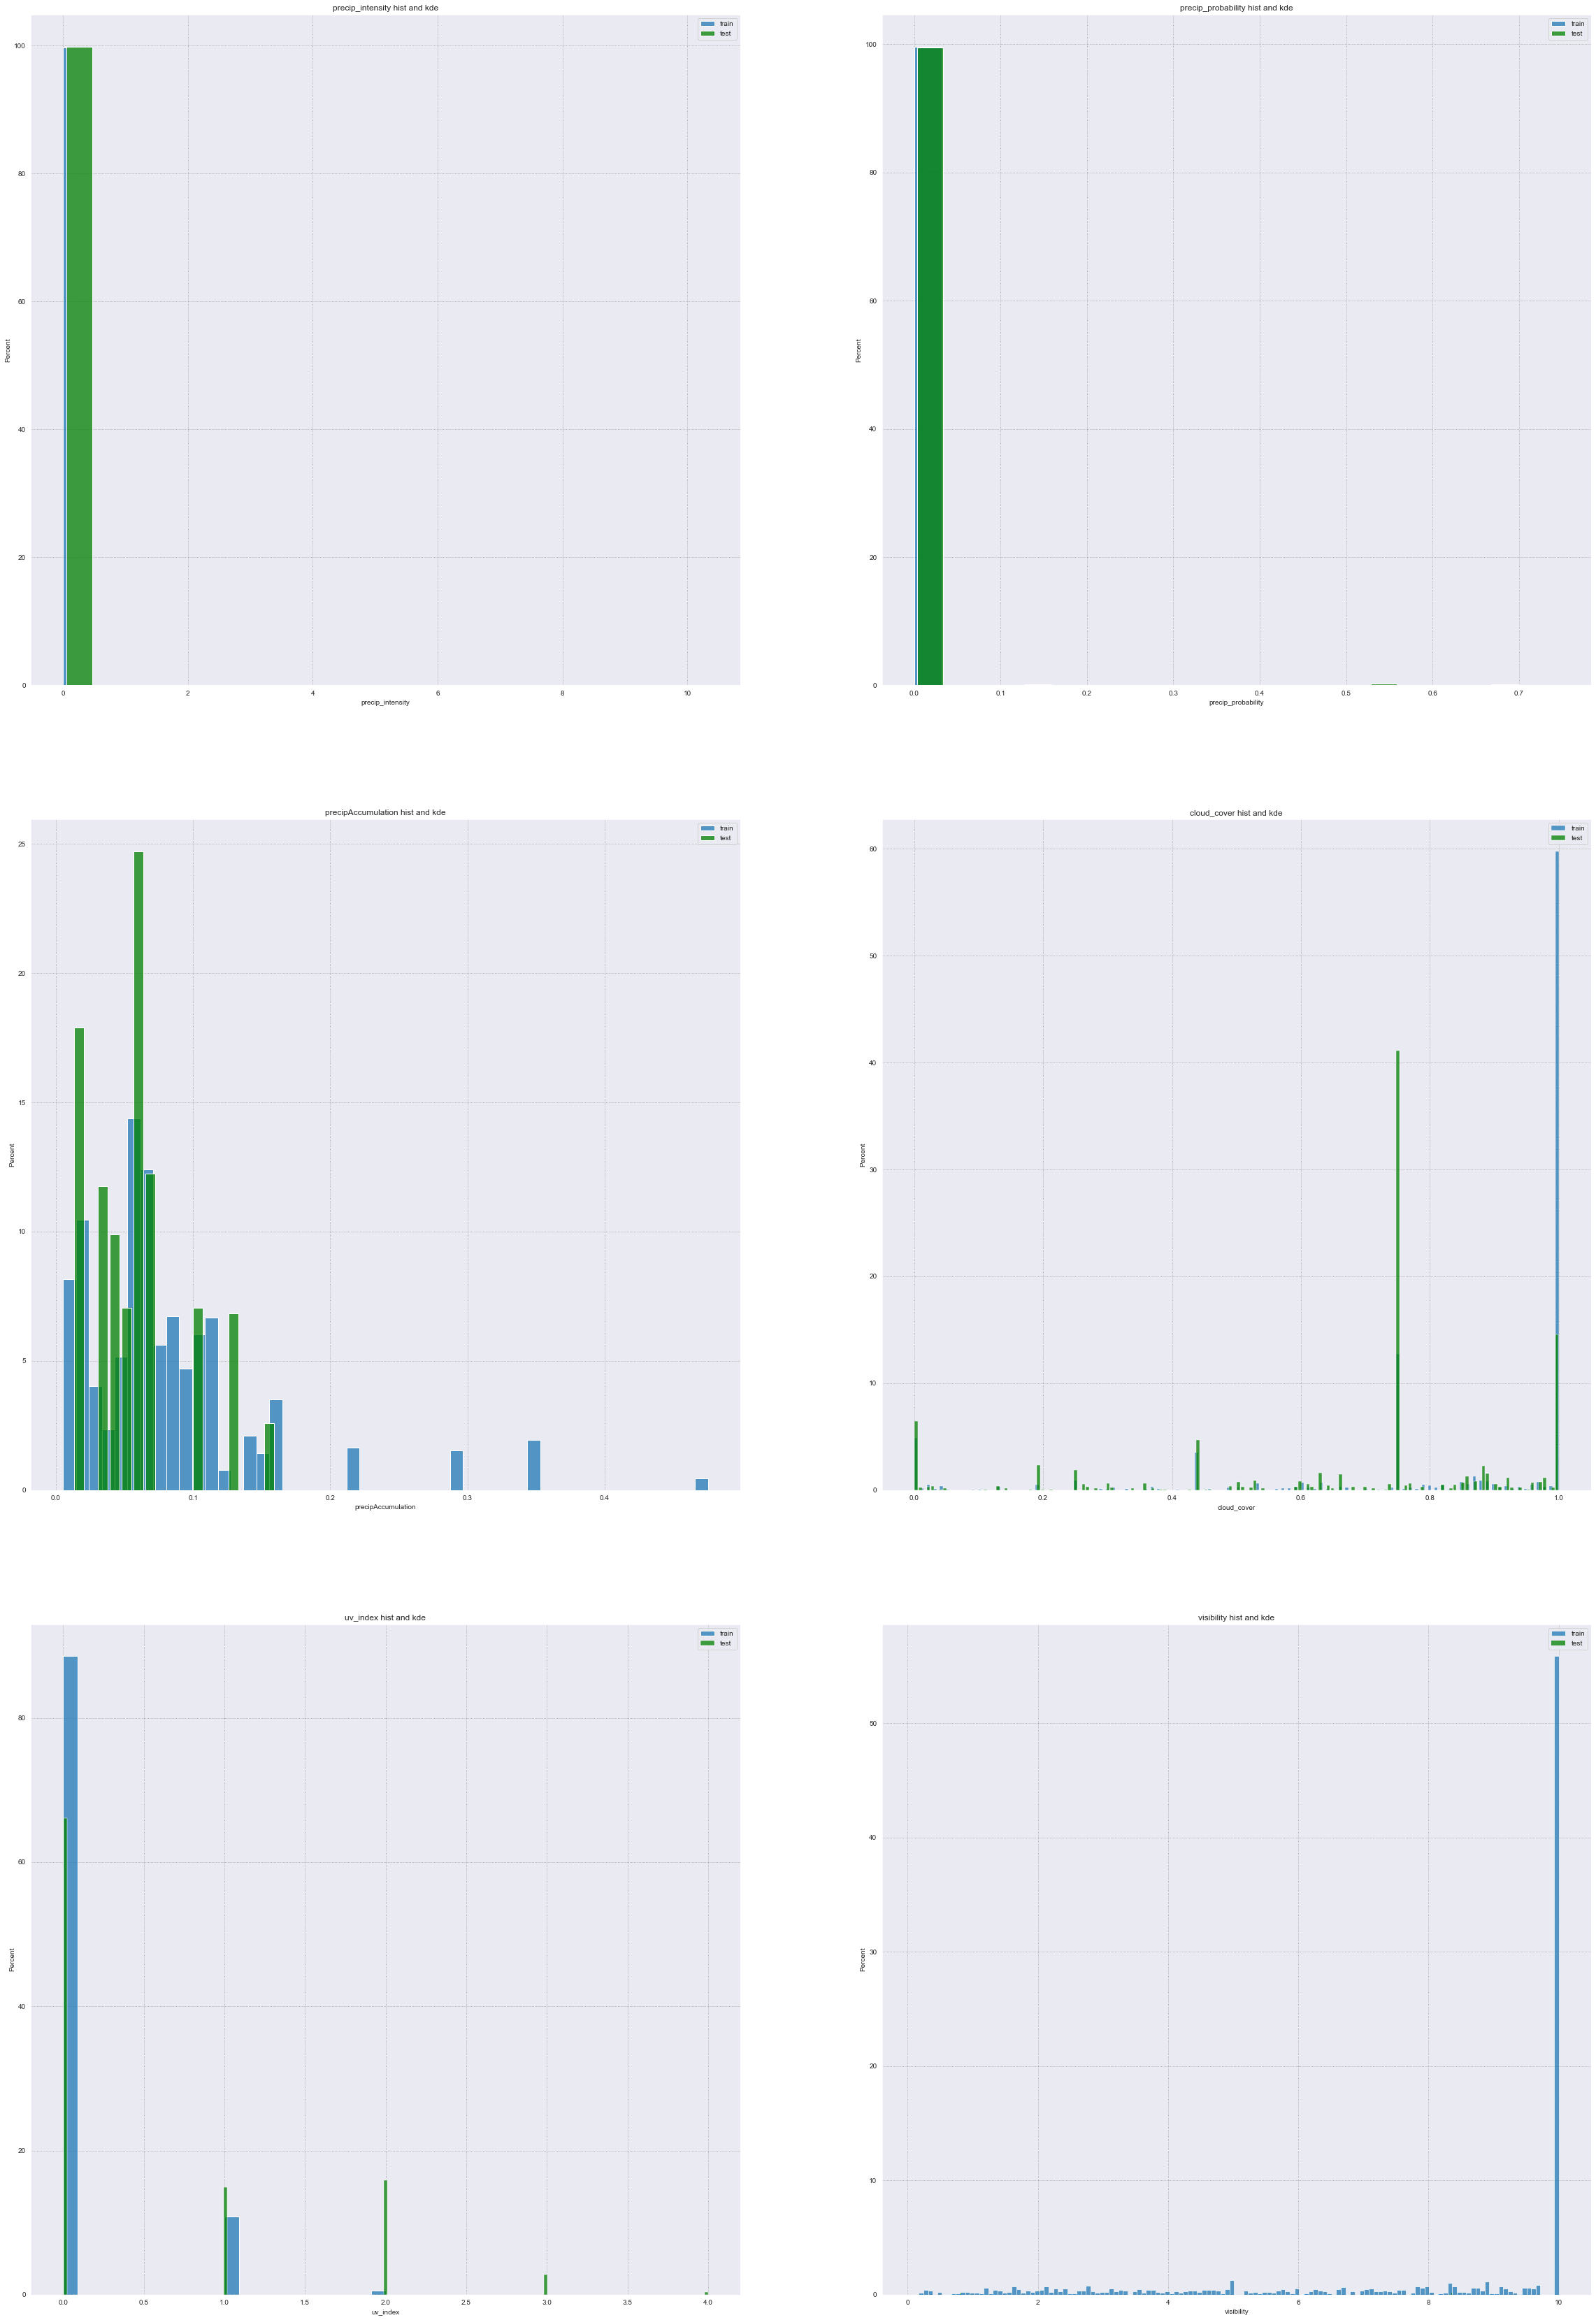

In [54]:
float_features = ['precip_intensity', 'precip_probability', 'precipAccumulation',\
                  'cloud_cover', 'uv_index', 'visibility']

fig = plt.figure(figsize=(40,60))
plt.axis('off')

for i, feat in enumerate(float_features):
    ax = fig.add_subplot(int(len(float_features) / 2), 2, i + 1)
    ax.set_title(f'{feat} hist and kde')
    sns.histplot(data=df[df['target'] == df['target']], x=feat, label='train', ax=ax, stat='percent')
    sns.histplot(data=df[df['target'] != df['target']], x=feat, label='test', ax=ax,\
                     color='green', stat='percent', shrink=.8)
    ax.legend(['train', 'test'])
    ax.set_xlabel(feat)

## Категориальные фичи


### Распределния признаков на обучении и тесте

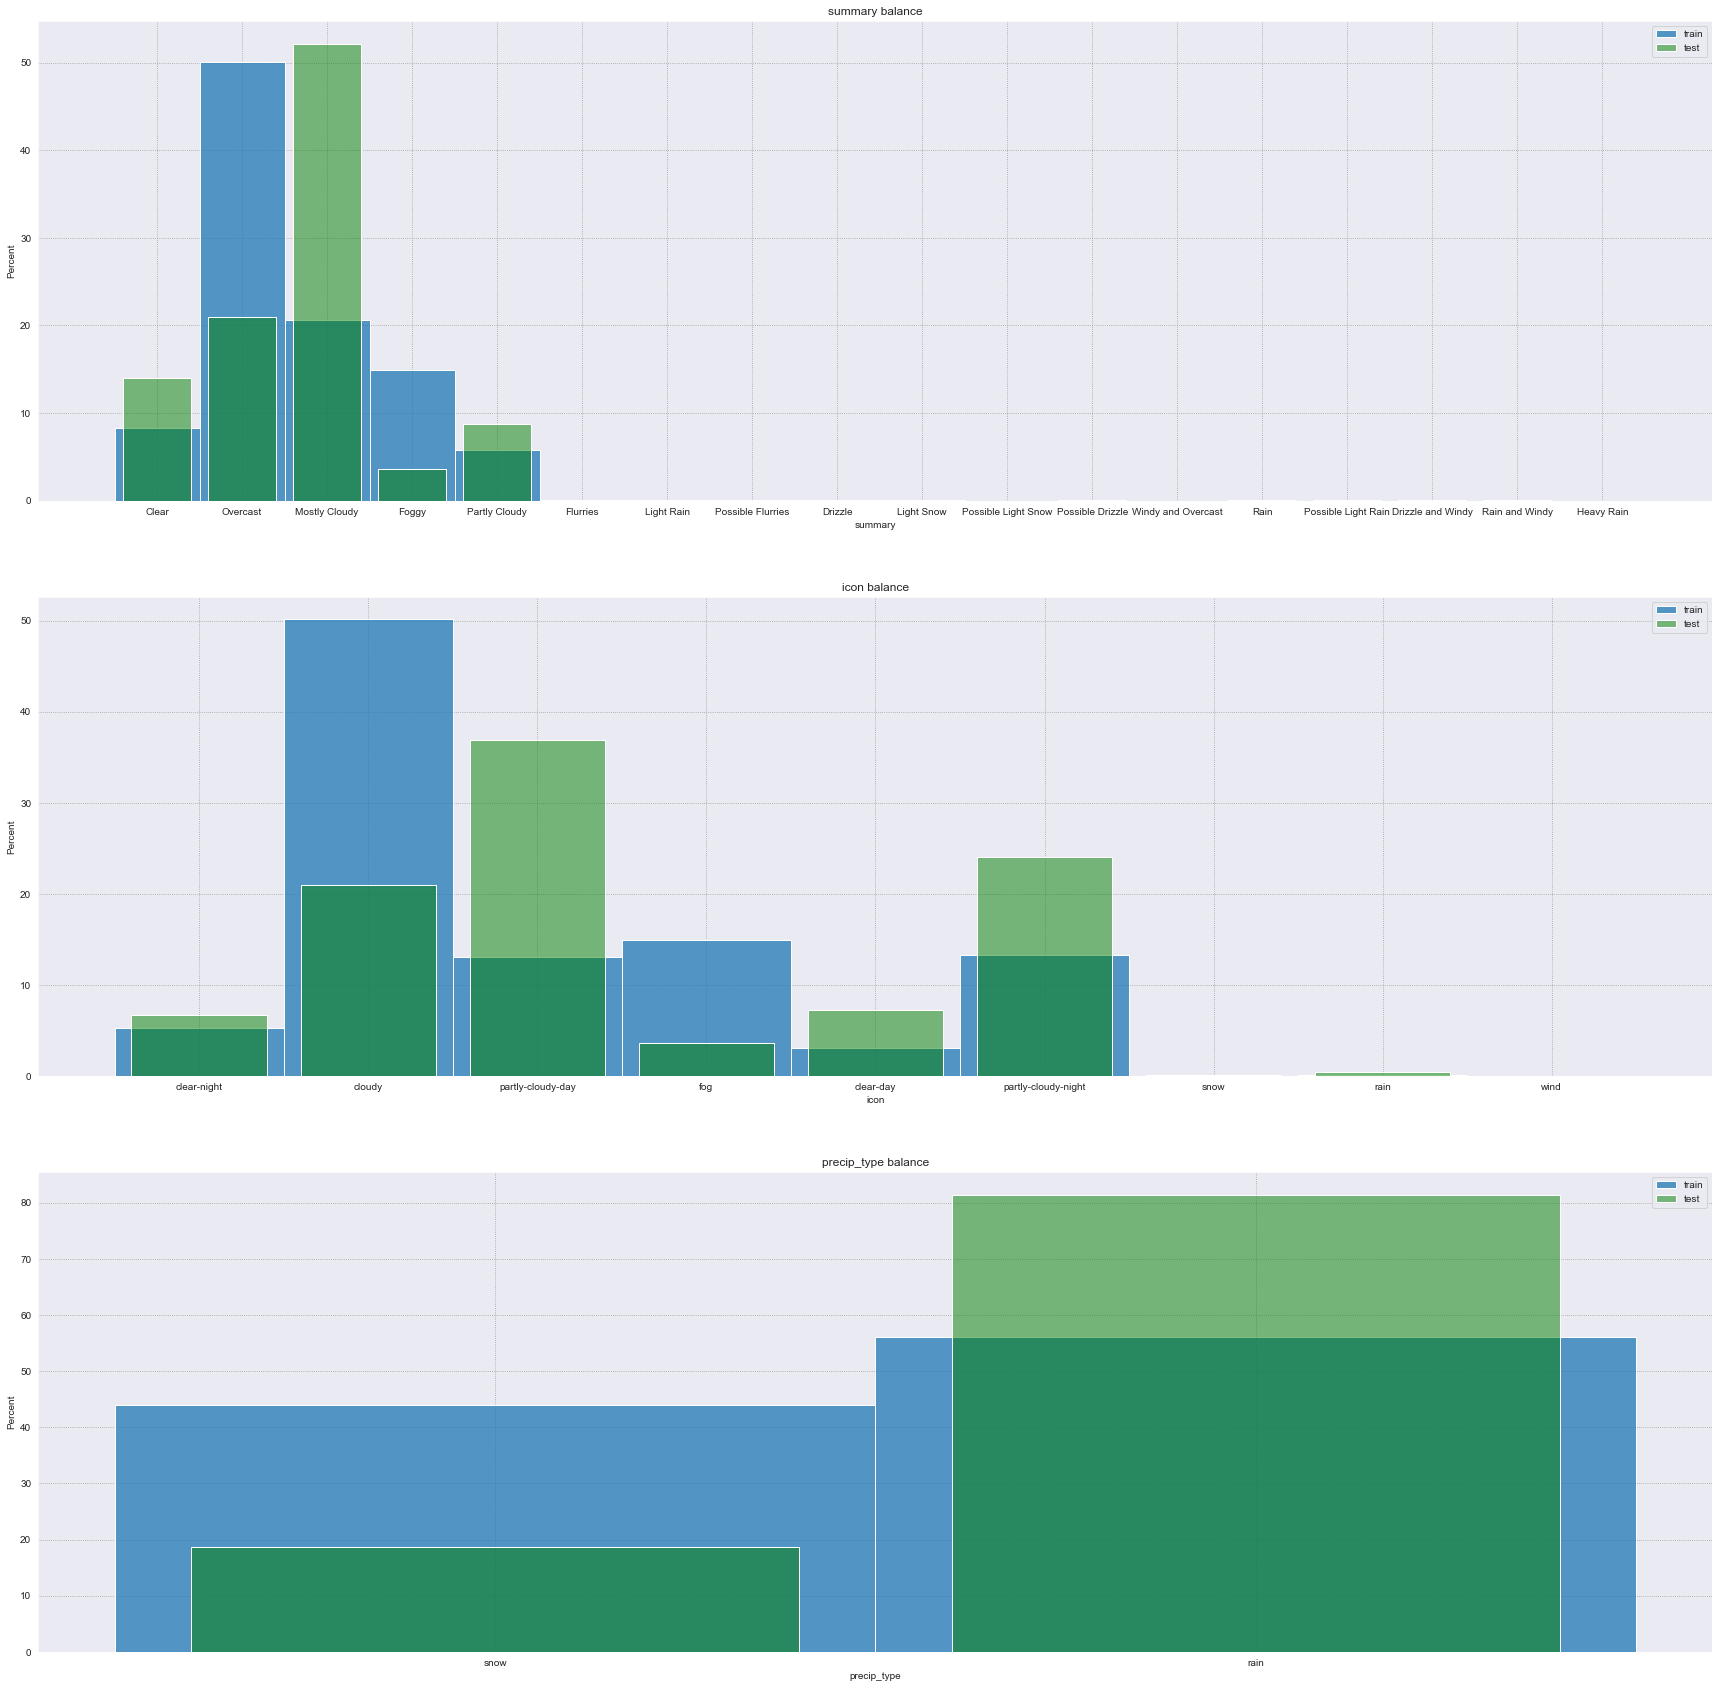

In [45]:
obj_features = ['summary', 'icon', 'precip_type']

fig = plt.figure(figsize=(30, 30))
plt.axis('off')

for i, feat in enumerate(obj_features):
    ax = fig.add_subplot(len(obj_features), 1, i + 1)
    ax.set_title(f'{feat} balance')
    sns.histplot(data=df[df['target'] == df['target']], x=feat, label='train', ax=ax, stat='percent')
    sns.histplot(data=df[df['target'] != df['target']], x=feat, label='test', ax=ax,\
                     color='green', stat='percent', shrink=.8, alpha=.5)
    ax.set_xlabel(feat)
    ax.legend(['train', 'test'])

Все распределения категориальных признаков довольно сильно отличаются

### Распределение признаков обучения по таргету

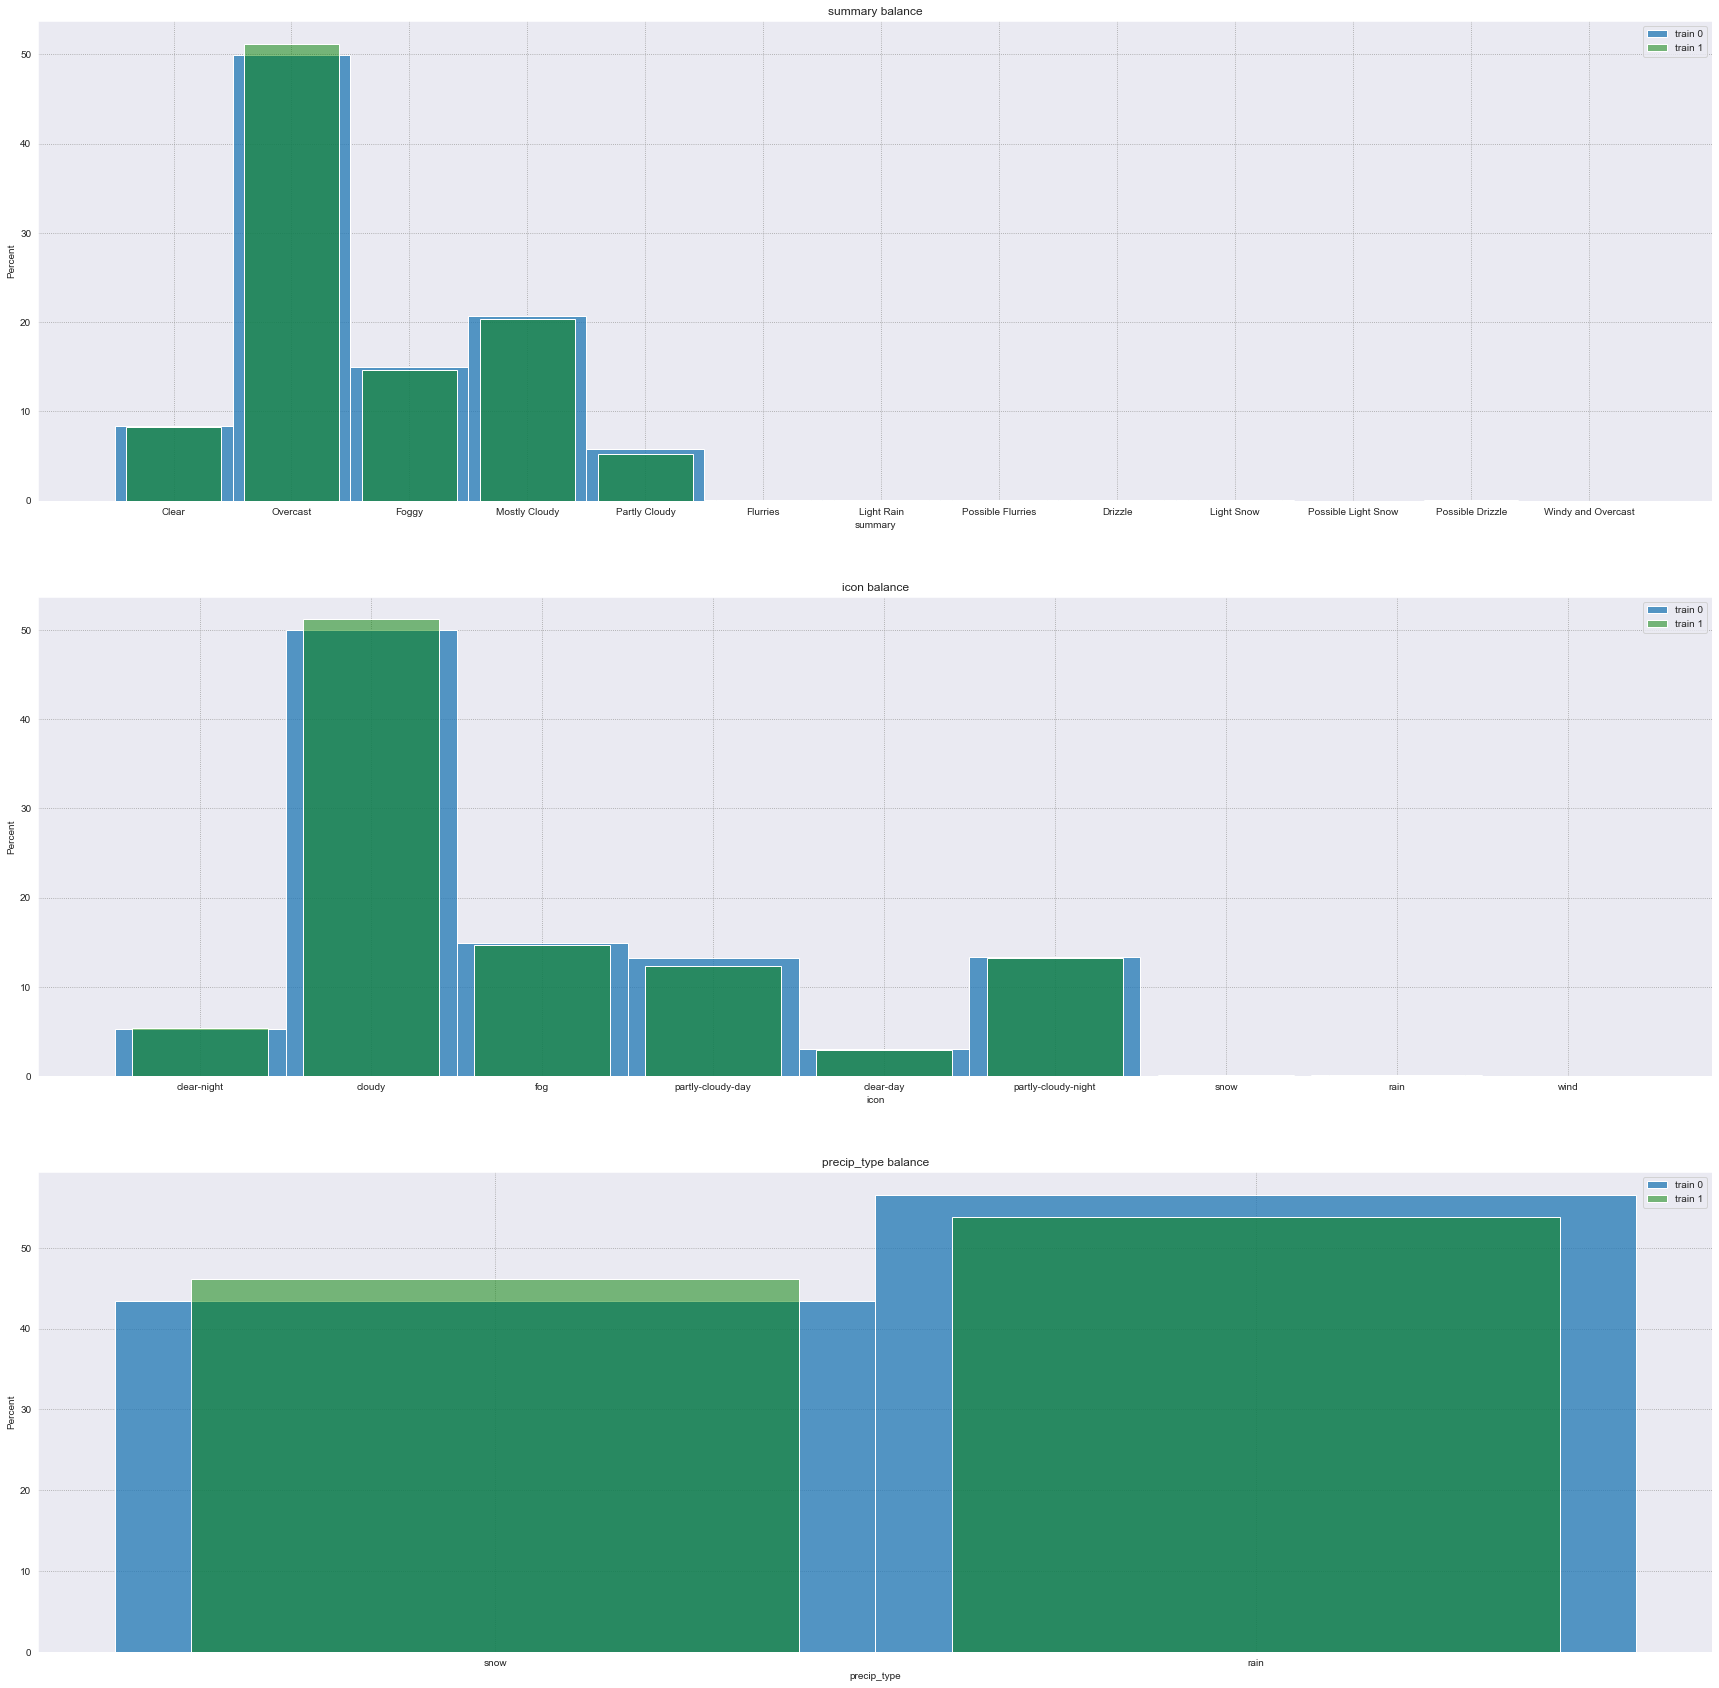

In [47]:
obj_features = ['summary', 'icon', 'precip_type']

fig = plt.figure(figsize=(30, 30))
plt.axis('off')

for i, feat in enumerate(obj_features):
    ax = fig.add_subplot(len(obj_features), 1, i + 1)
    ax.set_title(f'{feat} balance')
    sns.histplot(data=df[df['target'] == 0], x=feat, label='train 0', ax=ax, stat='percent')
    sns.histplot(data=df[df['target'] == 1], x=feat, label='train 1', ax=ax,\
                     color='green', stat='percent', shrink=.8, alpha=.5)
    ax.set_xlabel(feat)
    ax.legend(['train 0', 'train 1'])

А вот по таргету отличий практически нет, похоже это не лучшие признаки для обучения.